<a href="https://colab.research.google.com/github/theAkhileshRai/ComputerVision/blob/master/FCNSegmentationPASCAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Semantic Segmentation

!pip install -U --pre mxnet-cu101mkl  # updating mxnet to at least v1.6
!pip install git+https://github.com/d2l-ai/d2l-en # installing d2l

Requirement already up-to-date: mxnet-cu101mkl in /usr/local/lib/python3.6/dist-packages (1.6.0)
  Cloning https://github.com/d2l-ai/d2l-en to /tmp/pip-req-build-ts32b8d2
  Running command git clone -q https://github.com/d2l-ai/d2l-en /tmp/pip-req-build-ts32b8d2
  Created wheel for d2l: filename=d2l-0.11.4-cp36-none-any.whl size=31756 sha256=8e1dd040bfa58df06d2b60327e0a16a744577999149951960eb1c93c7b8ec380
  Stored in directory: /tmp/pip-ephem-wheel-cache-jyoeakg9/wheels/82/6f/b8/8422c7ed664272685e3d139b127f89df39d934704a14b2156c
Successfully built d2l


In [0]:
from mxnet import np, npx, init
from mxnet.gluon import nn,model_zoo
import d2l
from mxnet import gluon, image, init, np, npx
npx.set_np()

In [0]:
def trans_conv(X, K):
    h, w = K.shape
    Y = np.zeros((X.shape[0] + h - 1, X.shape[1] + w - 1))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Y[i: i + h, j: j + w] += X[i, j] * K
    return Y

In [5]:
X = np.array([[0, 1], [2, 3]])
K = np.array([[0, 1], [2, 3]])
trans_conv(X, K)

array([[ 0.,  0.,  1.],
       [ 0.,  4.,  6.],
       [ 4., 12.,  9.]])

In [6]:
X, K = X.reshape(1, 1, 2, 2), K.reshape(1, 1, 2, 2)
tconv = nn.Conv2DTranspose(1, kernel_size=2)
tconv.initialize(init.Constant(K))
tconv(X)

array([[[[ 0.,  0.,  1.],
         [ 0.,  4.,  6.],
         [ 4., 12.,  9.]]]])

In [7]:
pretrained_net = model_zoo.vision.resnet18_v2(pretrained=True)
pretrained_net.features[-4:], pretrained_net.output

(HybridSequential(
   (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=512)
   (1): Activation(relu)
   (2): GlobalAvgPool2D(size=(1, 1), stride=(1, 1), padding=(0, 0), ceil_mode=True, global_pool=True, pool_type=avg, layout=NCHW)
   (3): Flatten
 ), Dense(512 -> 1000, linear))

In [0]:
net = nn.HybridSequential()
for layer in pretrained_net.features[:-2]:
    net.add(layer)


In [9]:
X = np.random.uniform(size=(1, 3, 320, 480))
net(X).shape

(1, 512, 10, 15)

In [0]:
num_classes = 21
net.add(nn.Conv2D(num_classes, kernel_size=1),
        nn.Conv2DTranspose(
            num_classes, kernel_size=64, padding=16, strides=32))

In [0]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (np.arange(kernel_size).reshape(-1, 1),
          np.arange(kernel_size).reshape(1, -1))
    filt = (1 - np.abs(og[0] - center) / factor) * \
           (1 - np.abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return np.array(weight)

In [0]:
conv_trans = nn.Conv2DTranspose(3, kernel_size=4, padding=1, strides=2)
conv_trans.initialize(init.Constant(bilinear_kernel(3, 3, 4)))

In [0]:
img = image.imread('/content/catdog.jpg')
X = np.expand_dims(img.astype('float32').transpose(2, 0, 1), axis=0) / 255
Y = conv_trans(X)
out_img = Y[0].transpose(1, 2, 0)

input image shape: (561, 728, 3)
output image shape: (1122, 1456, 3)


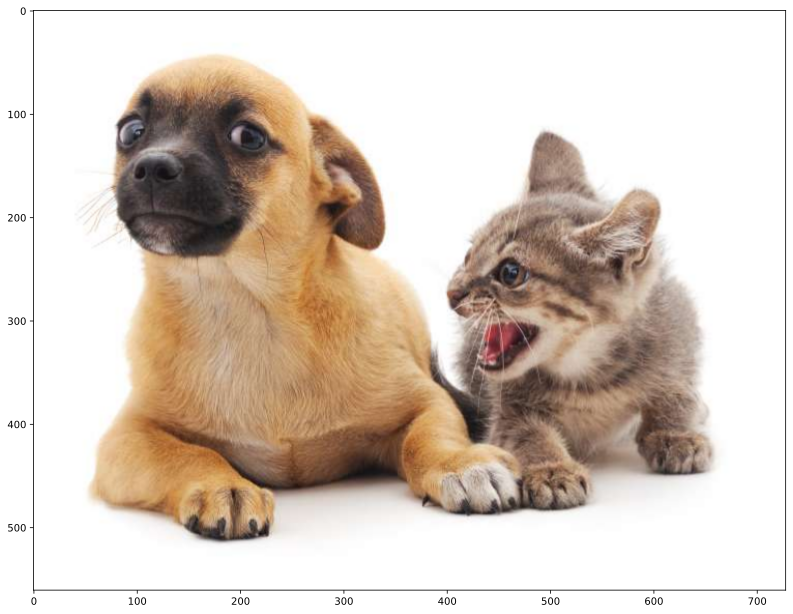

In [14]:
d2l.set_figsize((13.5, 12.5))
print('input image shape:', img.shape)
d2l.plt.imshow(img.asnumpy());
print('output image shape:', out_img.shape)


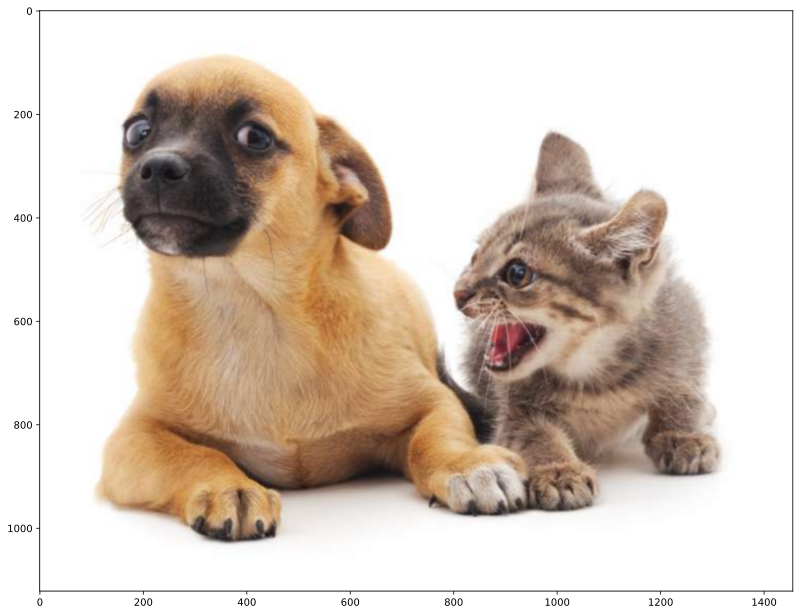

In [15]:
d2l.plt.imshow(out_img.asnumpy());

In [0]:
W = bilinear_kernel(num_classes, num_classes, 64)
net[-1].initialize(init.Constant(W))
net[-2].initialize(init=init.Xavier())

In [17]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


loss 0.293, train acc 0.901, test acc 0.852
77.6 examples/sec on [gpu(0)]


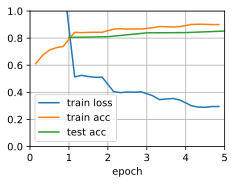

In [18]:
num_epochs, lr, wd, ctx = 5, 0.1, 1e-3, d2l.try_all_gpus()
loss = gluon.loss.SoftmaxCrossEntropyLoss(axis=1)
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd',
                        {'learning_rate': lr, 'wd': wd})
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, ctx)

In [0]:
def predict(img):
    X = test_iter._dataset.normalize_image(img)
    X = np.expand_dims(X.transpose(2, 0, 1), axis=0)
    pred = net(X.as_in_ctx(ctx[0])).argmax(axis=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

In [0]:
def label2image(pred):
    colormap = np.array(d2l.VOC_COLORMAP, ctx=ctx[0], dtype='uint8')
    X = pred.astype('int32')
    return colormap[X, :]

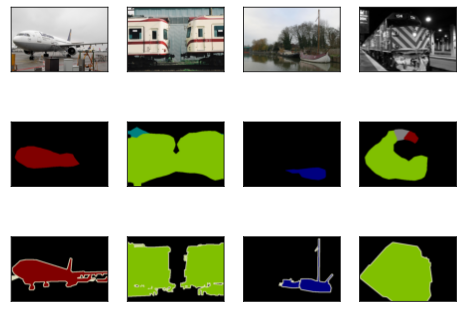

In [21]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 480, 320)
    X = image.fixed_crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X, pred, image.fixed_crop(test_labels[i], *crop_rect)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);